In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

data = pd.read_csv("../data/heart.csv")
X = data.drop(columns=['target'], axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2060)
max_index = 0
max_accuracy = 0
for i in range(1, 14):
    model = DecisionTreeClassifier(criterion='gini', max_depth=i, min_samples_split=10, random_state=2060)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_index = i
    print(f'Max depth: {i}, Accuracy: {accuracy}')
print(f'Max depth: {max_index}, Accuracy: {max_accuracy}')

Max depth: 1, Accuracy: 0.7658536585365854
Max depth: 2, Accuracy: 0.7609756097560976
Max depth: 3, Accuracy: 0.848780487804878
Max depth: 4, Accuracy: 0.8585365853658536
Max depth: 5, Accuracy: 0.8975609756097561
Max depth: 6, Accuracy: 0.926829268292683
Max depth: 7, Accuracy: 0.9414634146341463
Max depth: 8, Accuracy: 0.9463414634146341
Max depth: 9, Accuracy: 0.9414634146341463
Max depth: 10, Accuracy: 0.9414634146341463
Max depth: 11, Accuracy: 0.9414634146341463
Max depth: 12, Accuracy: 0.9414634146341463
Max depth: 13, Accuracy: 0.9414634146341463
Max depth: 8, Accuracy: 0.9463414634146341


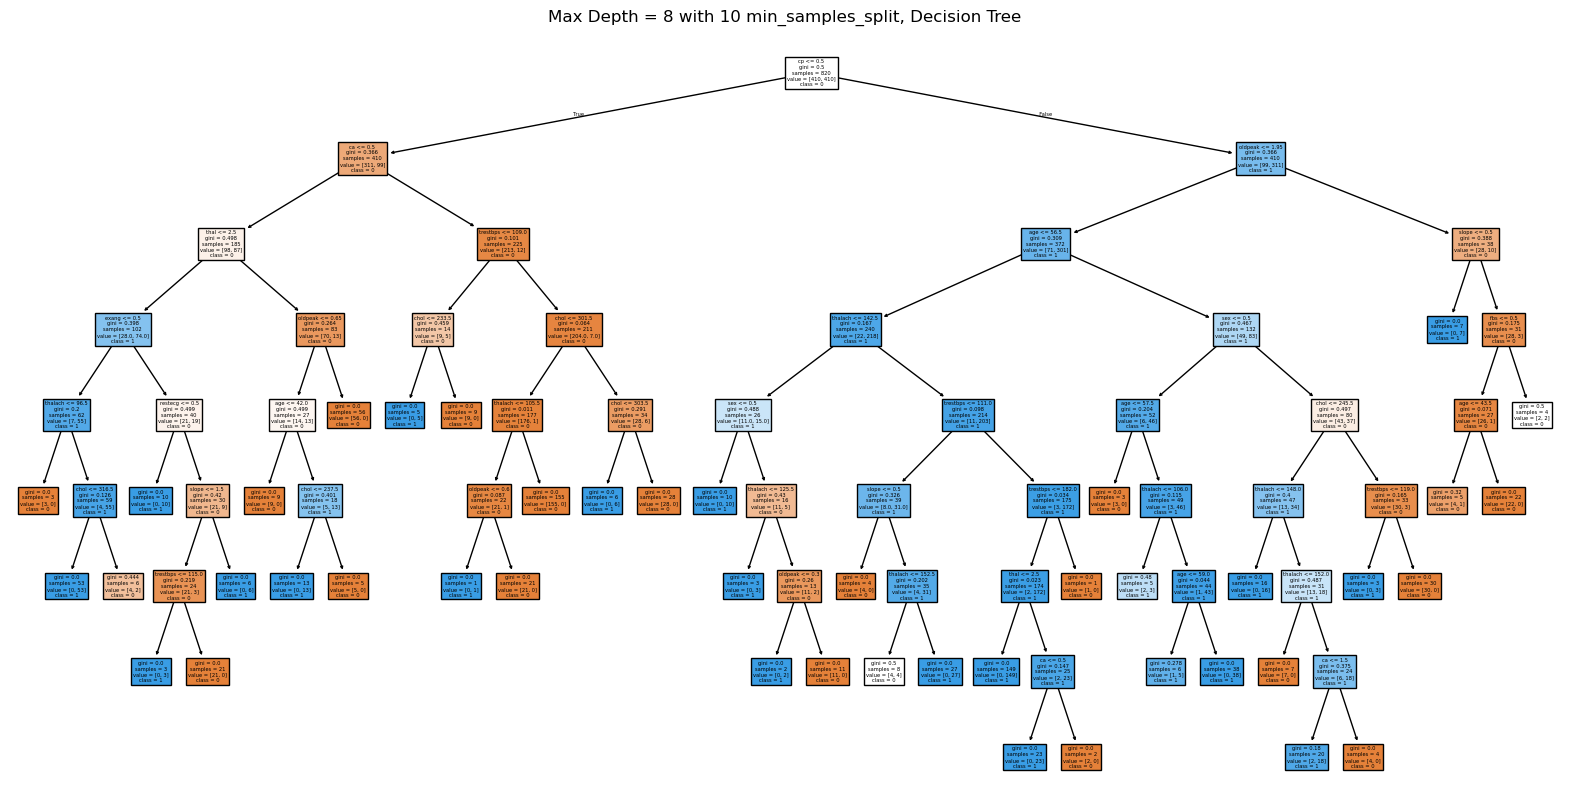

In [4]:
model = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=10, random_state=2060)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=[str(cls) for cls in model.classes_], filled=True)
plt.title("Max Depth = 8 with 10 min_samples_split, Decision Tree")
plt.savefig("../graph/decision_tree_scikitlearn.png")
plt.show()

# Code implementation without scikit-learn

Columns:

id, age (continuous), sex (01), chestpain cp(1-4), trestbps (continuous), chol (continuous), fbs (01), restecg(continuous), thalach (continuous), exang(01), oldpeak(continuous), slope (categorical), ca(categorical), thal (categorical), num (target yes no)

In [5]:
import graphviz
from IPython.display import display

def visualize_tree(tree):
    dot = graphviz.Digraph()
    def add_nodes_edges(node, dot, counter):
        if node is None:
            return counter
        node_id = str(counter)
        if node.isleaf:
            label = f"Leaf\nLabel: {node.label}"
        else:
            label = (f"Feature {node.index_split_on}\n"
                     f"≤ {node.split_value:.2f}\n"
                     f"Gini: {node.info.get('gain', 0):.2f}\n"
                     f"Samples: {node.info.get('num_samples', 0)}")
        dot.node(node_id, label)
        counter += 1
        if node.left:
            left_id = str(counter)
            counter = add_nodes_edges(node.left, dot, counter)
            dot.edge(node_id, left_id, label="True")
        if node.right:
            right_id = str(counter)
            counter = add_nodes_edges(node.right, dot, counter)
            dot.edge(node_id, right_id, label="False")
        return counter
    add_nodes_edges(tree.root, dot, 0)
    return dot

In [ ]:
import math
def node_score_entropy(prob):
    '''
        TODO:
        Calculate the node score using the entropy of the subdataset and return it.
        For a dataset with 2 classes, C(p) = -p * log(p) - (1-p) * log(1-p)
        For the purposes of this calculation, assume 0*log0 = 0.
        HINT: remember to consider the range of values that p can take!
    '''
    # HINT: If p < 0 or p > 1 then entropy = 0
    if prob == 0 or prob == 1:
        return 0
    return -prob * math.log(prob) - (1-prob) * math.log(1-prob)

def gini_for_node(data):
    labels = [row[-1] for row in data]
    _, counts = np.unique(labels, return_counts=True)
    prob = counts / len(data)
    gini = 1 - np.sum(prob ** 2)
    return gini

def gini_for_split(data, left, right):
    gini_left = gini_for_node(left)
    gini_right = gini_for_node(right)
    gini = (len(left) / len(data)) * gini_left + (len(right) / len(data)) * gini_right
    return gini

def continuous_split(data, feature, value):
    left = [row for row in data if row[feature] <= value]
    right = [row for row in data if row[feature] > value]
    return left, right

def cate_split(data, feature):
    feature_val = [row[feature] for row in data]
    val = np.mean(np.unique(feature_val))
    left = [row for row in data if row[feature] == val]
    right = [row for row in data if row[feature] != val]
    return left, right

class Node:
    '''
    Helper to construct the tree structure.
    '''
    def __init__(self, left=None, right=None, depth=0, index_split_on=0, split_value = None, isleaf=False, label=1):
        self.left = left
        self.right = right
        self.depth = depth
        self.index_split_on = index_split_on
        self.split_value = split_value
        self.isleaf = isleaf
        self.label = label
        self.info = {}


    def _set_info(self, gain, num_samples):
        '''
        Helper function to add to info attribute.
        You do not need to modify this. 
        '''
        self.info['gain'] = gain
        self.info['num_samples'] = num_samples


class DecisionTree:

    def __init__(self, data, max_depth=14):
        self.max_depth = max_depth
        labels = [row[-1] for row in data]
        self.majority_class = max(set(labels), key=labels.count)
        self.root = Node(label = self.majority_class)
        indices = list(range(len(data[0]) - 1))
        self.build_tree(self.root, data, indices)

    def build_tree(self, node, data, indices):
        if self._is_terminal(node, data):
            node.isleaf = True
            node.label = self._get_majority_class(data)
            return

        best_feature, best_split, mini_gini = self.choose_split(data)
        if best_feature is None:
            node.isleaf = True
            node.label = self._get_majority_class(data)
            return

        node.index_split_on = best_feature
        node.split_value = best_split
        node._set_info(mini_gini, len(data))

        feature_values = [row[best_feature] for row in data]
        unique_val = np.unique(feature_values)
        if len(unique_val) > 2:
            left_data, right_data = continuous_split(data, best_feature, best_split)
        else:
            left_data, right_data = cate_split(data, best_feature)

        node.left = Node(depth=node.depth + 1)
        node.right = Node(depth=node.depth + 1)

        self.build_tree(node.left, left_data, indices)
        self.build_tree(node.right, right_data, indices)
    
    def predict(self, features):
        '''
        Helper function to predict the label given a row of features.
        You do not need to modify this.
        '''
        return self._predict_recurs(self.root, features)


    def accuracy(self, data):
        '''
        Helper function to calculate the accuracy on the given data.
        You do not need to modify this.
        '''
        return 1 - self.loss(data)


    def loss(self, data):
        '''
        Helper function to calculate the loss on the given data.
        You do not need to modify this.
        '''
        cnt = 0.0
        test_Y = [row[-1] for row in data]
        for i in range(len(data)):
            prediction = self.predict(data[i])
            if (prediction != test_Y[i]):
                cnt += 1.0
        return cnt/len(data)
    
    def _is_terminal(self, node, data):
        if len(data) == 0:
            return True
        labels = [row[-1] for row in data]
        if len(set(labels)) == 1:
            return True
        if node.depth >= self.max_depth:
            return True
        return False

    def _get_majority_class(self, data):
        labels = [row[-1] for row in data]
        if labels:
            return max(set(labels), key=labels.count)
        return self.majority_class
    
    def _predict_recurs(self, node, row):
        if node.isleaf or node.index_split_on is None:
            return node.label
        split_index = node.index_split_on
        split_value = node.split_value
        if row[split_index] <= split_value:
            return self._predict_recurs(node.left, row)
        else:
            return self._predict_recurs(node.right, row)
    
    def choose_split(self, data):
        '''Traverse through each column and each average value of the values in the column to find the best split.'''
        # data is like [[patient1], [patient2], ...] [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], ...] each column is a feature
        # len(data[0]) is the number of features 13
        # len(data) = number of patients
        best_feature = None
        best_split = None
        mini_gini = float('inf')
        features = len(data[0]) # how many features we have, 13
        # we need to know what feature and what value to split on
        for f in range(features - 1):
            unique_val = np.unique([row[f] for row in data])
            sorted_data = sorted(data, key=lambda x: x[f])# sort the data by the feature
            if len(unique_val) > 2:
                for i in range(len(data) - 1): # number of patients
                    split = (sorted_data[i][f] + sorted_data[i + 1][f]) / 2
                    left, right = continuous_split(data, f, split)
                    if not left or not right:
                        continue
                    # calculate the gini index for this split
                    gini = gini_for_split(data, left, right)
                    if gini < mini_gini:
                        mini_gini = gini
                        best_feature = f
                        best_split = split
            else:
                left, right = cate_split(data, f)
                gini = gini_for_split(data, left, right)
                if gini < mini_gini:
                    mini_gini = gini
                    best_feature = f
                    best_split = np.mean(unique_val)
        return best_feature, best_split, mini_gini

In [7]:
data = pd.read_csv('../data/heart.csv')
data.replace('?', np.nan, inplace=True)
data = data.dropna()

object_columns = data.select_dtypes(include=['object']).columns.tolist()
for col in object_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

X = data.drop(columns=['target']).to_numpy().tolist()
y = data['target'].to_numpy().tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2060)

data = [features + [label] for label, features in zip(y_train, X_train)]
tree = DecisionTree(data, max_depth=10)
accuracy = tree.accuracy(data)
print("training", accuracy)

data = [features + [label] for label, features in zip(y_test, X_test)]
accuracy = tree.accuracy(data)
print("testing", accuracy)
dot = visualize_tree(tree)
dot.render('../graph/testing_tree', format='png', cleanup=True)

Majority class: 0
training 0.9890243902439024
testing 0.9658536585365853


'../graph/testing_tree.png'